<a href="https://colab.research.google.com/github/felicia2025-hue/Bankcruptcy-Prediction/blob/main/Bankcruptcy_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pemilihan Dataset & Explore Dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

df = pd.read_csv('/content/bankcrupt.csv')
df.columns = df.columns.str.strip()
df.rename(columns={'Bankrupt?': 'Bankrupt'}, inplace=True)

# Lihat struktur data
print(df.info())
print(df.describe())
print(df['Bankrupt'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt                                                 6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

**Data Understanding**

Goal: To predict whether a company is at risk of bankruptcy

Target: Bankcrupt (1/0)

Features: Financial Ratio

**Data Cleaning**

In [ ]:
print("duplicate: ")
print(df.duplicated().sum())

duplicate: 
0


In [ ]:
# Missing Value
print("Missing value each column:")
print(df.isnull().sum())

Missing value tiap kolom:
Bankrupt                                                   0
ROA(C) before interest and depreciation before interest    0
ROA(A) before interest and % after tax                     0
ROA(B) before interest and depreciation after tax          0
Operating Gross Margin                                     0
                                                          ..
Liability to Equity                                        0
Degree of Financial Leverage (DFL)                         0
Interest Coverage Ratio (Interest expense to EBIT)         0
Net Income Flag                                            0
Equity to Liability                                        0
Length: 96, dtype: int64


**Data Manipulation**

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Bankrupt'])
y = df['Bankrupt']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**EDA (Exploratory Data Analysis)**

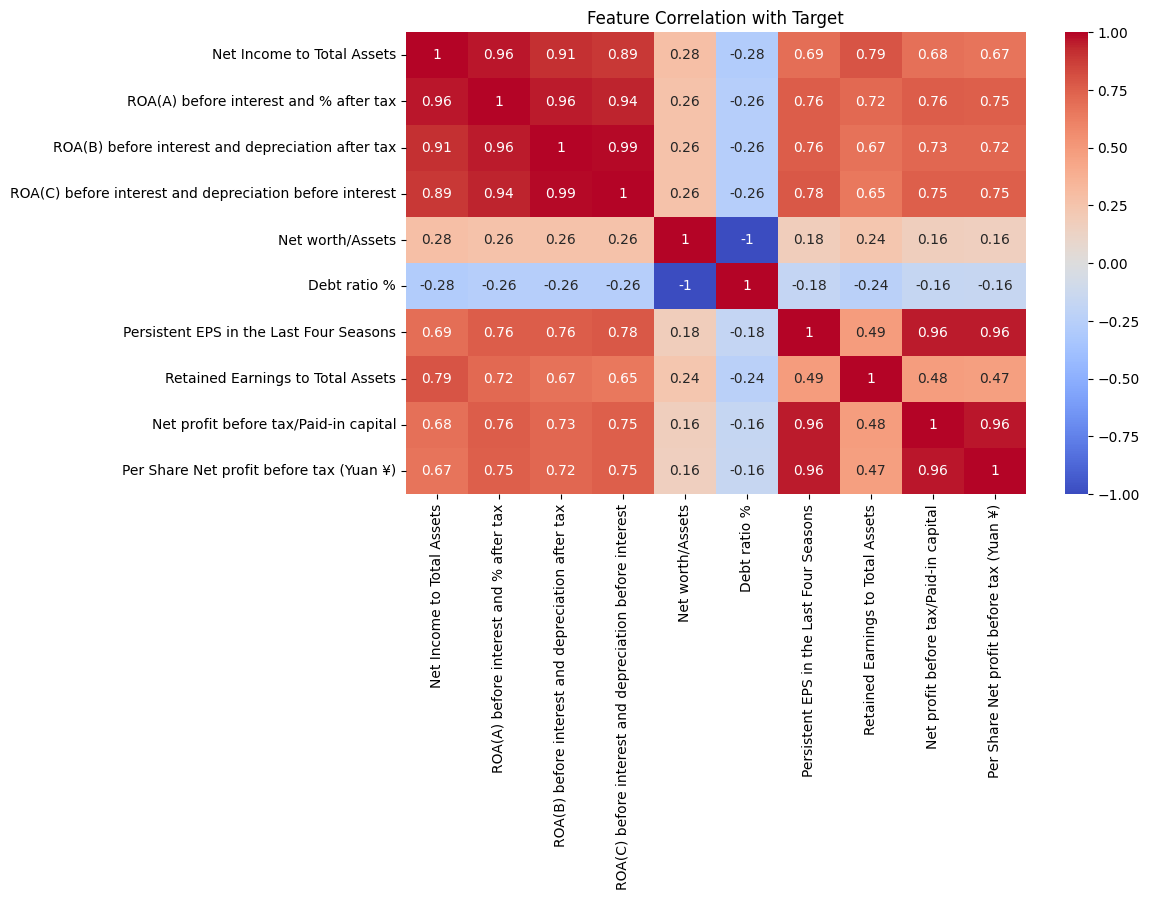

In [ ]:
# Correlation heatmap
correlation_with_target = df.corr()['Bankrupt'].abs().sort_values(ascending=False)
top_features = correlation_with_target[1:11].index

plt.figure(figsize=(10, 6))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Target")
plt.show()

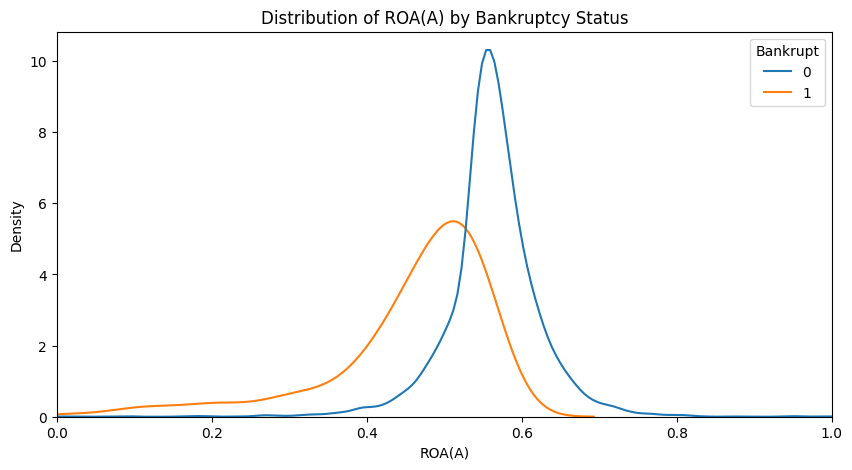

In [ ]:
# Distribusi Fitur Profitabilitas
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='ROA(A) before interest and % after tax', hue='Bankrupt', common_norm=False)
plt.title("Distribution of ROA(A) by Bankruptcy Status")
plt.xlabel("ROA(A)")
plt.ylabel("Density")
plt.xlim(0, 1)
plt.show()

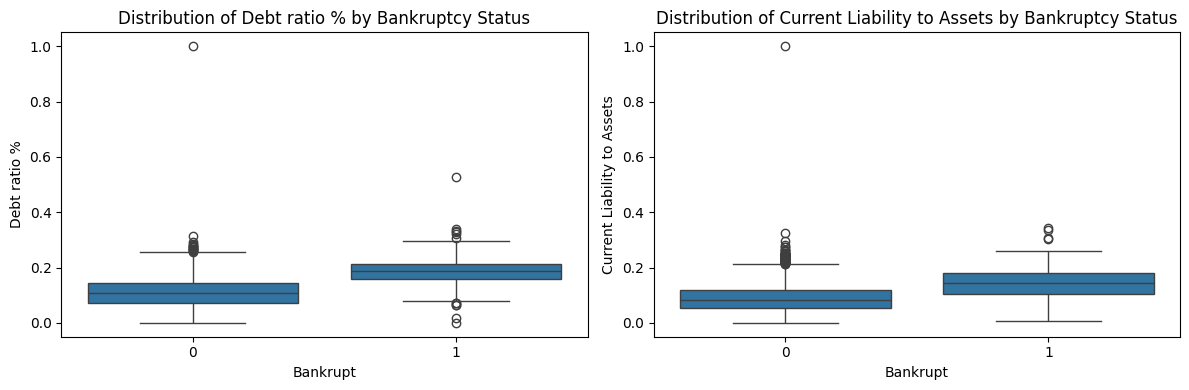

In [ ]:
# Rasio Utang dan Kewajiban Jangka Pendek
plt.figure(figsize=(12, 4))
for i, col in enumerate(["Debt ratio %", "Current Liability to Assets"]):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x="Bankrupt", y=col, data=df)
    plt.title(f"Distribution of {col} by Bankruptcy Status")
plt.tight_layout()
plt.show()

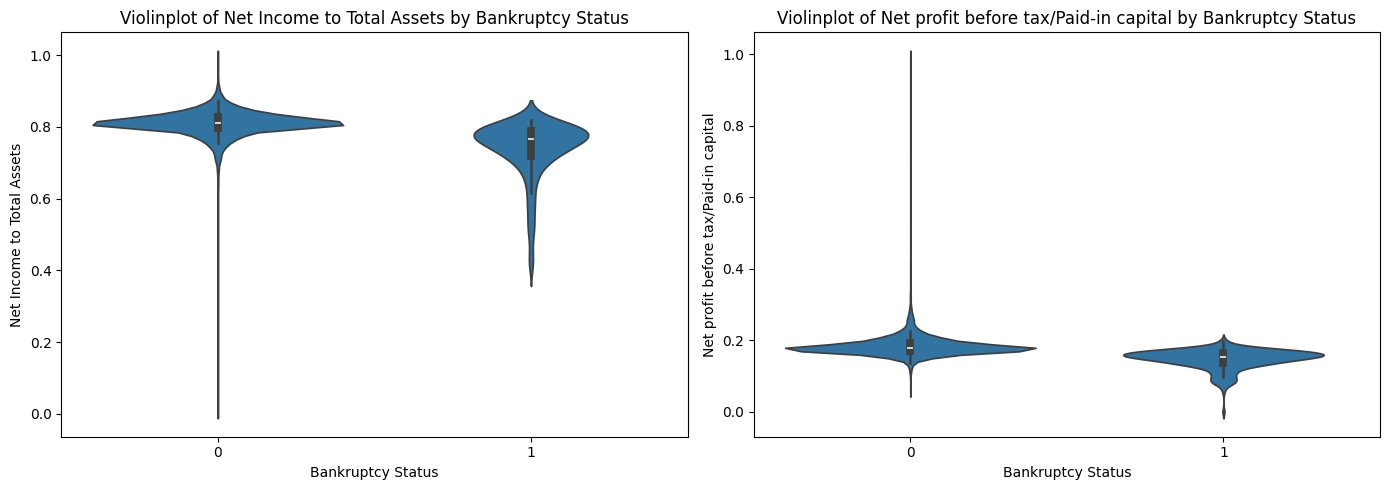

In [ ]:
# Distribution of Profit Efficiency Ratios
features = ['Net Income to Total Assets', 'Net profit before tax/Paid-in capital']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, col in enumerate(features):
    sns.violinplot(data=df, x='Bankrupt', y=col, ax=axes[i])
    axes[i].set_title(f'Violinplot of {col} by Bankruptcy Status')
    axes[i].set_xlabel('Bankruptcy Status')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

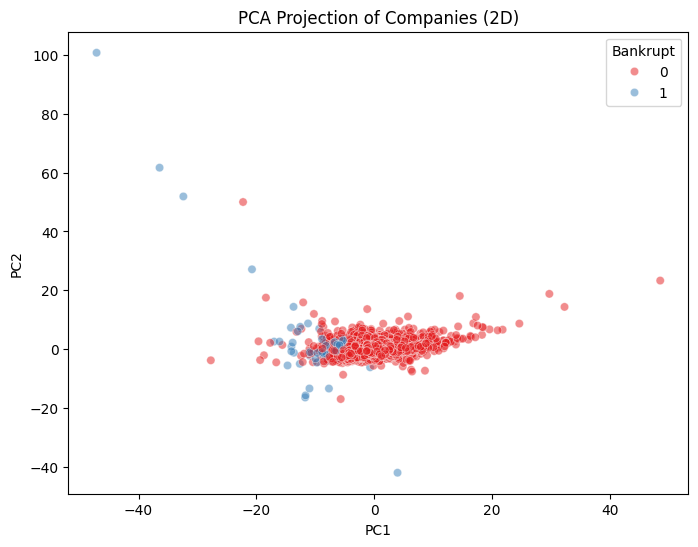

In [ ]:
# Clustering : Indikasi Grup Risiko
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(df.drop(columns='Bankrupt'))
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['Bankrupt'] = df['Bankrupt']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Bankrupt', alpha=0.5, palette='Set1')
plt.title("PCA Projection of Companies (2D)")
plt.show()

**Feature Engineering**

In [ ]:
# Drop multicollinear features (correlation > 0.95)
corr_matrix = pd.DataFrame(X_scaled).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_reduced = pd.DataFrame(X_scaled).drop(columns=to_drop)

In [ ]:
before = X_scaled.shape[1]
after = X_reduced.shape[1]
removed = before - after

# Buat DataFrame ringkasan
summary_df = pd.DataFrame({
    'Description': ['Features Before', 'Features After', 'Features Removed'],
    'Count': [before, after, removed]
})
summary_df

,Description,Count
0,Features Before,95
1,Features After,79
2,Features Removed,16


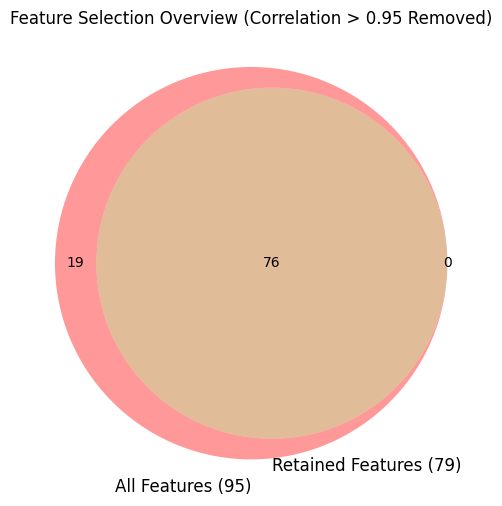

In [ ]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
# Convert X_scaled to DataFrame with proper column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Recalculate the retained features for safety
corr_matrix = X_scaled_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
X_reduced_df = X_scaled_df.drop(columns=to_drop)

# Create feature sets
all_features = set(X_scaled_df.columns)
retained_features = set(X_reduced_df.columns)

# Generate Venn Diagram
plt.figure(figsize=(6, 6))
venn2 ([all_features, retained_features], set_labels=('All Features (95)', 'Retained Features (79)'))
plt.title("Feature Selection Overview (Correlation > 0.95 Removed)")
plt.show()

**Machine Learning**

In [ ]:
# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train Random Forest
model_before = RandomForestClassifier(random_state=42)
model_before.fit(X_train, y_train)

# Predict
y_pred_before = model_before.predict(X_test)

# Evaluate
print("=== Evaluation Before SMOTE ===")
print(classification_report(y_test, y_pred_before))
print(confusion_matrix(y_test, y_pred_before))

=== Evaluation Before SMOTE ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1980
           1       0.45      0.14      0.21        66

    accuracy                           0.97      2046
   macro avg       0.71      0.57      0.60      2046
weighted avg       0.96      0.97      0.96      2046

[[1969   11]
 [  57    9]]


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Random Forest on balanced data
model_after = RandomForestClassifier(random_state=42)
model_after.fit(X_train_smote, y_train_smote)

# Predict on original test set
y_pred_after = model_after.predict(X_test)

# Evaluate
print("=== Evaluation After SMOTE ===")
print(classification_report(y_test, y_pred_after))
print(confusion_matrix(y_test, y_pred_after))

=== Evaluation After SMOTE ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1980
           1       0.41      0.52      0.46        66

    accuracy                           0.96      2046
   macro avg       0.70      0.75      0.72      2046
weighted avg       0.97      0.96      0.96      2046

[[1932   48]
 [  32   34]]


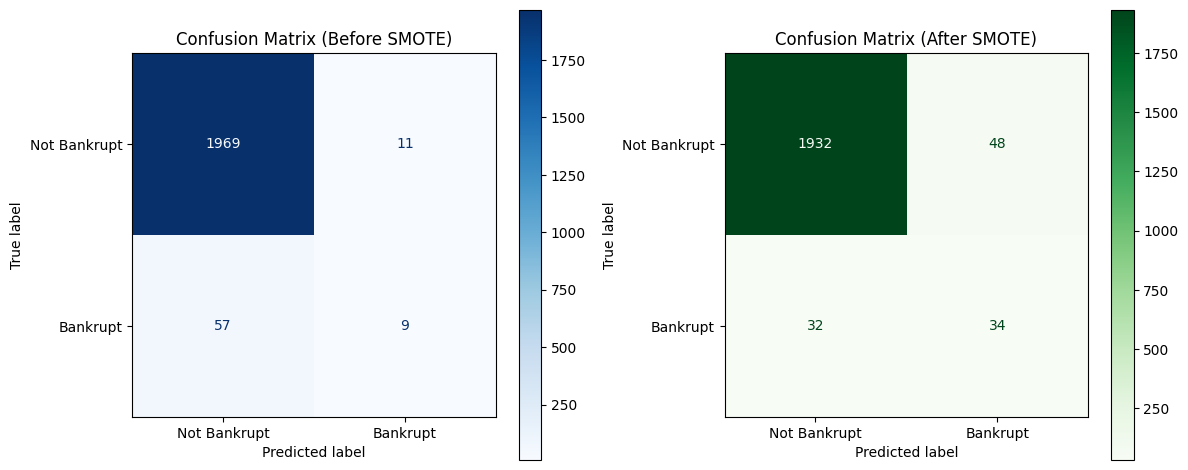

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
cm_before = confusion_matrix(y_test, y_pred_before)
disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before, display_labels=['Not Bankrupt', 'Bankrupt'])
disp_before.plot(ax=axes[0], values_format='d', cmap='Blues')
axes[0].set_title('Confusion Matrix (Before SMOTE)')

# After SMOTE
cm_after = confusion_matrix(y_test, y_pred_after)
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after, display_labels=['Not Bankrupt', 'Bankrupt'])
disp_after.plot(ax=axes[1], values_format='d', cmap='Greens')
axes[1].set_title('Confusion Matrix (After SMOTE)')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Before SMOTE:")
print(classification_report(y_test, y_pred_before))

print("After SMOTE:")
print(classification_report(y_test, y_pred_after))

Before SMOTE:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1980
           1       0.45      0.14      0.21        66

    accuracy                           0.97      2046
   macro avg       0.71      0.57      0.60      2046
weighted avg       0.96      0.97      0.96      2046

After SMOTE:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1980
           1       0.41      0.52      0.46        66

    accuracy                           0.96      2046
   macro avg       0.70      0.75      0.72      2046
weighted avg       0.97      0.96      0.96      2046



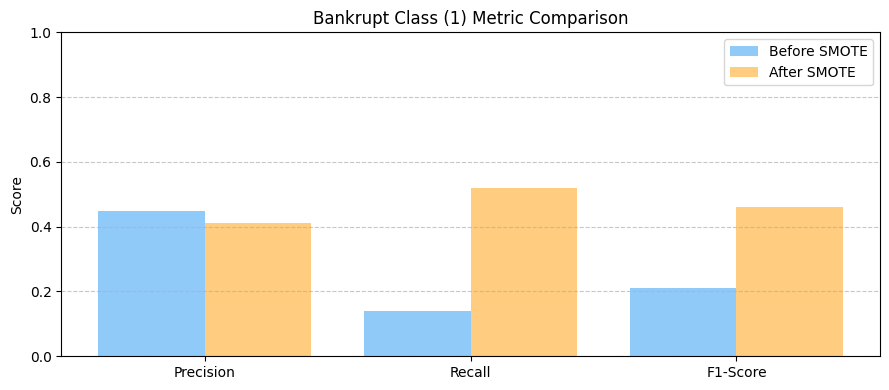

In [ ]:
labels = ['Precision', 'Recall', 'F1-Score']
before = [0.45, 0.14, 0.21]  # class 1 (bankrupt)
after = [0.41, 0.52, 0.46]

x = range(len(labels))

plt.figure(figsize=(9, 4))
plt.bar(x, before, width=0.4, label='Before SMOTE', align='center', color='#90CAF9')  # soft blue
plt.bar([p + 0.4 for p in x], after, width=0.4, label='After SMOTE', align='center', color='#FFCC80')  # soft orange

plt.xticks([p + 0.2 for p in x], labels)
plt.ylabel('Score')
plt.title('Bankrupt Class (1) Metric Comparison')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()